#### PROJET MACHINE LEARNING: CLASSIFICATION DES DILEMMES ÉTHIQUES
#### Dataset: hendrycks/ethics - VERSION HAUTE PERFORMANCE

INSTALLATION DES DÉPENDANCES

In [1]:
!pip install --upgrade pip 
!pip install datasets scikit-learn xgboost lightgbm matplotlib seaborn joblib pandas numpy scipy nltk imbalanced-learn tqdm

In [2]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import joblib
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

FIG_DIR = 'figures'
os.makedirs(FIG_DIR, exist_ok=True)
RANDOM_STATE = 42


CHARGEMENT DES DONNÉES

In [ ]:
print('\nChargement dataset...')
try:
    from datasets import load_dataset
    dataset = load_dataset('hendrycks/ethics', 'commonsense')
    train_data = pd.DataFrame(dataset['train'])
    test_data  = pd.DataFrame(dataset['test'])
    print('✓ Dataset chargé depuis Hugging Face')
except Exception as e:
    raise RuntimeError("Erreur chargement dataset. Assurez-vous d'avoir installé `datasets` et d'avoir accès internet.\n" + str(e))

print(f"Train: {len(train_data)}, Test: {len(test_data)}")
print(f" Distribution Train (counts): {train_data['label'].value_counts().to_dict()}")



📥 Chargement dataset...
✓ Dataset chargé depuis Hugging Face
✓ Train: 13910, Test: 3964
 Distribution Train (counts): {0: 7556, 1: 6354}


PRÉTRAITEMENT (avec EDA séparé et justification)

In [ ]:
def preprocess_text(text):
    """
    Prétraitement léger en gardant les informations importantes pour l'analyse morale.
    - mise en minuscule
    - marquage explicite des négations (préservation du signal de sens)
    - suppression d'URLs et de caractères non alphabétiques (sauf underscore utilisé par les marqueurs)
    - remplacement des contractions simples
    Justification: conserver les indices sémantiques (négation, modaux, pronoms) utiles pour la classification d'éthique.
    """
    text = str(text)
    text = text.lower()
    text = re.sub(r"\b(not|no|never|neither|nobody|none)\b", r"NOT_\1", text)
    contractions = {
        "won't": "will not",
        "can't": "cannot",
        "n't": " not",
        "'re": " are",
        "'ve": " have",
        "'ll": " will",
        "'d": " would",
    }
    for k, v in contractions.items():
        text = text.replace(k, v)

    text = re.sub(r'http\S+|www\S+', '', text)

    text = re.sub(r'[^a-zA-Z\s_]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

print('\n Prétraitement...')
train_data['processed'] = train_data['input'].apply(preprocess_text)
test_data['processed']  = test_data['input'].apply(preprocess_text)
print('✓ Prétraitement terminé')



 Prétraitement...
✓ Prétraitement terminé


In [ ]:
def save_fig(fig, name):
    path = os.path.join(FIG_DIR, name)
    fig.savefig(path, dpi=200, bbox_inches='tight')
    print(f" ✓ Sauvegardé: {path}")

EDA: Diagrammes et statistiques

 ✓ Sauvegardé: figures\class_distribution_train.png


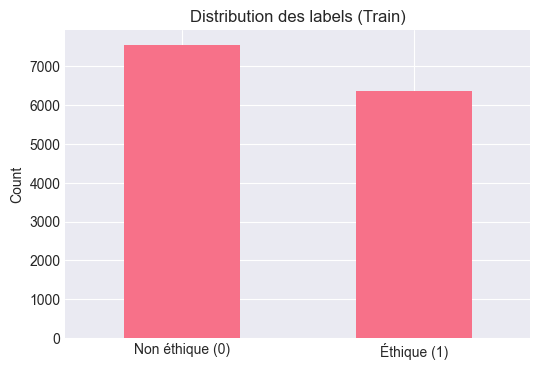

In [ ]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)
train_data['label'].value_counts().sort_index().plot(kind='bar', ax=ax)
ax.set_xticklabels(['Non éthique (0)', 'Éthique (1)'], rotation=0)
ax.set_title('Distribution des labels (Train)')
ax.set_ylabel('Count')
sns.despine()
save_fig(fig, 'class_distribution_train.png')
fig.show()

 ✓ Sauvegardé: figures\text_length_distributions.png


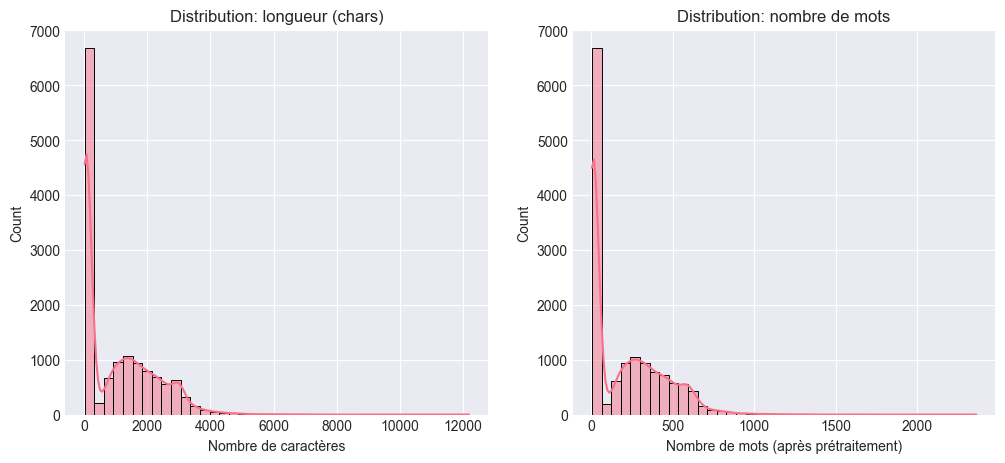

In [ ]:
train_data['char_count'] = train_data['input'].apply(len)
train_data['word_count'] = train_data['processed'].apply(lambda x: len(x.split()))
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(1,2,1)
sns.histplot(train_data['char_count'], bins=40, ax=ax1, kde=True)
ax1.set_title('Distribution: longueur (chars)')
ax1.set_xlabel('Nombre de caractères')
ax2 = fig.add_subplot(1,2,2)
sns.histplot(train_data['word_count'], bins=40, ax=ax2, kde=True)
ax2.set_title('Distribution: nombre de mots')
ax2.set_xlabel('Nombre de mots (après prétraitement)')
save_fig(fig, 'text_length_distributions.png')
fig.show()

 ✓ Sauvegardé: figures\top_unigrams.png
 ✓ Sauvegardé: figures\top_bigrams.png


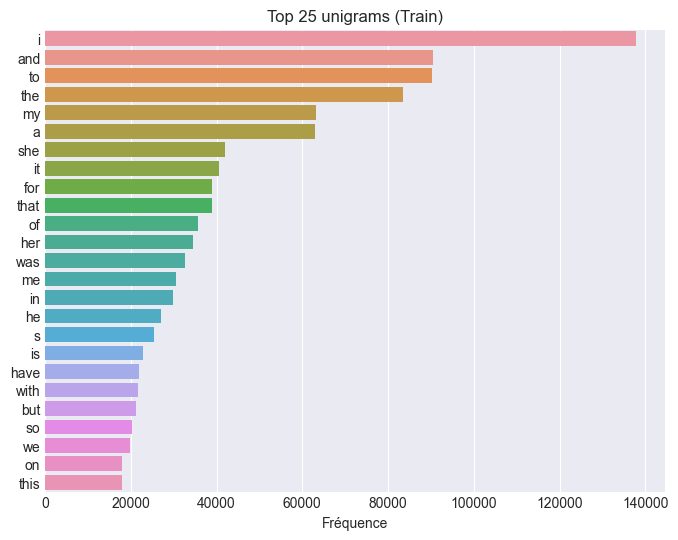

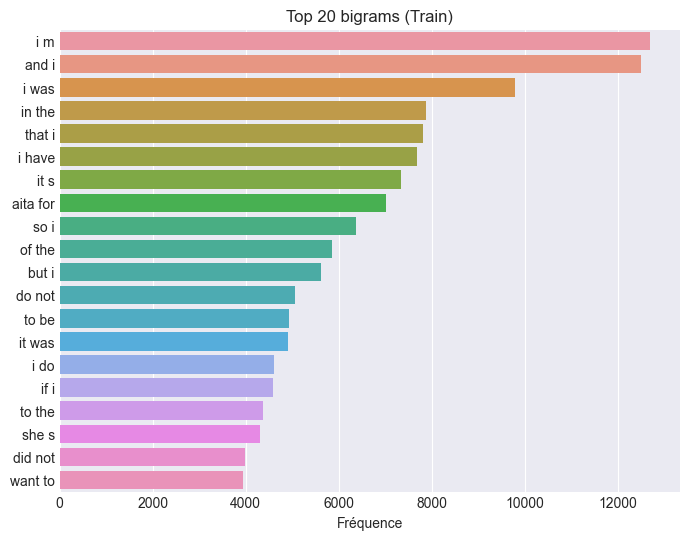

In [ ]:
def get_top_ngrams(corpus, n=1, top_k=20):
    counts = Counter()
    for doc in corpus:
        tokens = doc.split()
        if n == 1:
            counts.update(tokens)
        else:
            grams = [' '.join(tokens[i:i+n]) for i in range(len(tokens)-n+1)]
            counts.update(grams)
    return counts.most_common(top_k)

top_uni = get_top_ngrams(train_data['processed'].tolist(), n=1, top_k=25)
top_bi  = get_top_ngrams(train_data['processed'].tolist(), n=2, top_k=20)

fig = plt.figure(figsize=(8,6))
if top_uni:
    words, freqs = zip(*top_uni)
    sns.barplot(x=list(freqs), y=list(words))
    plt.title('Top 25 unigrams (Train)')
    plt.xlabel('Fréquence')
    save_fig(fig, 'top_unigrams.png')
fig.show()

fig = plt.figure(figsize=(8,6))
if top_bi:
    words, freqs = zip(*top_bi)
    sns.barplot(x=list(freqs), y=list(words))
    plt.title('Top 20 bigrams (Train)')
    plt.xlabel('Fréquence')
    save_fig(fig, 'top_bigrams.png')
fig.show()

 ✓ Sauvegardé: figures\negation_distribution.png


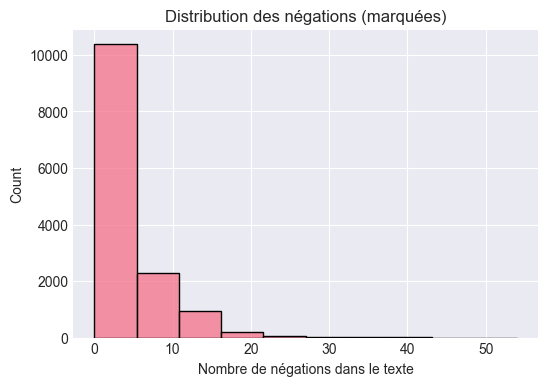

In [ ]:
neg_patterns = ['NOT_not', 'NOT_no', 'NOT_never', 'NOT_neither', 'NOT_nobody', 'NOT_none']
def count_negations(s):
    return sum(s.count(p) for p in neg_patterns)
train_data['neg_count'] = train_data['processed'].apply(count_negations)
fig = plt.figure(figsize=(6,4))
sns.histplot(train_data['neg_count'], bins=10, kde=False)
plt.title('Distribution des négations (marquées)')
plt.xlabel('Nombre de négations dans le texte')
save_fig(fig, 'negation_distribution.png')
fig.show()

In [ ]:
eda_summary = train_data[['char_count','word_count','neg_count']].describe().T
eda_summary['skew'] = train_data[['char_count','word_count','neg_count']].skew()
print('\n📊 Résumé statistiques descriptives (Train):')
print(eda_summary)
eda_summary.to_csv(os.path.join(FIG_DIR, 'eda_summary_table.csv'))
print(f" ✓ Sauvegardé: {os.path.join(FIG_DIR, 'eda_summary_table.csv')}")



📊 Résumé statistiques descriptives (Train):
              count         mean          std   min   25%    50%     75%  \
char_count  13910.0  1023.483968  1141.815613  10.0  56.0  667.0  1811.0   
word_count  13910.0   202.696765   225.394483   3.0  11.0  132.0   358.0   
neg_count   13910.0     3.328181     4.866873   0.0   0.0    0.0     6.0   

                max      skew  
char_count  12198.0  1.120849  
word_count   2361.0  1.099726  
neg_count      54.0  2.042488  
 ✓ Sauvegardé: figures\eda_summary_table.csv


FEATURE ENGINEERING

In [ ]:
class TextSelector(BaseEstimator, TransformerMixin):
    """Récupère la colonne texte (ex: 'processed') - renvoie un array de strings."""
    def __init__(self, key='processed'):
        self.key = key
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.key].values

class TfidfWrapper(BaseEstimator, TransformerMixin):
    """Wrapper pour TfidfVectorizer qui conserve le vecteur après fit."""
    def __init__(self, **tfidf_kwargs):
        self.tfidf_kwargs = tfidf_kwargs
    def fit(self, X, y=None):
        X = np.asarray(X)
        self.vec_ = TfidfVectorizer(**self.tfidf_kwargs)
        self.vec_.fit(X)
        return self
    def transform(self, X):
        X = np.asarray(X)
        return self.vec_.transform(X)

class AdvancedManualFeatureExtractor(BaseEstimator, TransformerMixin):
    """
    Extraie des features linguistiques et structurels.
    - Option d'utiliser spaCy / VADER si installés (meilleure qualité)
    - Fallback à méthodes regex/lexicon si non disponibles.
    Retourne numpy array (n_samples, n_features)
    """
    def __init__(self, use_spacy=False, use_vader=False):
        self.use_spacy = use_spacy
        self.use_vader = use_vader

    def fit(self, X, y=None):
        self.has_spacy = False
        self.has_vader = False
        try:
            if self.use_spacy:
                import spacy
                self.nlp = spacy.load('en_core_web_sm', disable=['ner'])
                self.has_spacy = True
        except Exception:
            self.has_spacy = False
        try:
            if self.use_vader:
                from nltk.sentiment.vader import SentimentIntensityAnalyzer
                self.vader = SentimentIntensityAnalyzer()
                self.has_vader = True
        except Exception:
            self.has_vader = False

        self.pos_lex = set(['right', 'good', 'fair', 'honest', 'help', 'kind', 'care', 'save', 'protect'])
        self.neg_lex = set(['wrong', 'bad', 'unfair', 'lie', 'cheat', 'steal', 'hurt', 'kill', 'harm'])
        self.modal_verbs = set(['should','must','ought','need','could','would','might','may','shall'])
        self.pronouns_1p = set(['i','me','my','mine','we','us','our','ours'])
        self.pronouns_2p = set(['you','your','yours'])
        self.pronouns_3p = set(['he','she','they','them','his','her','their','theirs'])
        return self

    def _estimate_syllables(self, word):
        w = word.lower()
        vowels = 'aeiouy'
        count = 0
        prev_v = False
        for ch in w:
            is_v = ch in vowels
            if is_v and not prev_v:
                count += 1
            prev_v = is_v
        if w.endswith('e'):
            count = max(1, count - 1)
        return max(1, count)

    def transform(self, X):
        df = X.reset_index(drop=True)
        docs = df['processed'].fillna('').astype(str).tolist()
        texts_raw = df['input'].fillna('').astype(str).tolist()

        rows = []
        for raw, proc in zip(texts_raw, docs):
            tokens = proc.split()
            char_count = len(raw)
            word_count = len(tokens)
            avg_word_len = np.mean([len(w) for w in tokens]) if tokens else 0.0
            unique_word_ratio = (len(set(tokens)) / (word_count + 1e-9)) if word_count>0 else 0.0

            qmark = int('?' in raw)
            exclaim = int('!' in raw)
            punctuation_count = len(re.findall(r'[^\w\s]', raw))
            uppercase_words = sum(1 for w in raw.split() if sum(1 for c in w if c.isupper()) > 1)

            negation_count = proc.count('NOT_')
            negated_moral_pos = 0
            negated_moral_neg = 0
            toks = proc.split()
            for i, t in enumerate(toks):
                if t.startswith('NOT_'):
                    window = toks[i+1:i+4]
                    for w in window:
                        if w in self.pos_lex:
                            negated_moral_pos += 1
                        if w in self.neg_lex:
                            negated_moral_neg += 1

            moral_pos_count = sum(proc.split().count(w) for w in self.pos_lex)
            moral_neg_count = sum(proc.split().count(w) for w in self.neg_lex)
            moral_balance = moral_pos_count - moral_neg_count

            cnt_1p = sum(proc.split().count(p) for p in self.pronouns_1p)
            cnt_2p = sum(proc.split().count(p) for p in self.pronouns_2p)
            cnt_3p = sum(proc.split().count(p) for p in self.pronouns_3p)

            modal_count = sum(proc.split().count(m) for m in self.modal_verbs)

            sentences = re.split(r'[.!?]+', raw)
            sentence_lens = [len(s.split()) for s in sentences if s.strip()]
            avg_sent_len = np.mean(sentence_lens) if sentence_lens else 0.0
            avg_syll_per_word = np.mean([self._estimate_syllables(w) for w in tokens]) if tokens else 0.0
            flesch_like = 206.835 - 1.015 * (avg_sent_len if avg_sent_len>0 else 0.0) - 84.6 * (avg_syll_per_word if avg_syll_per_word>0 else 0.0)

            sentiment_compound = 0.0
            if self.has_vader:
                try:
                    vs = self.vader.polarity_scores(proc)
                    sentiment_compound = vs.get('compound', 0.0)
                except Exception:
                    sentiment_compound = 0.0
            else:
                sentiment_compound = (moral_pos_count - moral_neg_count) / (word_count+1)

            row = [
                char_count, word_count, avg_word_len, unique_word_ratio,
                punctuation_count, qmark, exclaim, uppercase_words,
                negation_count, negated_moral_pos, negated_moral_neg,
                moral_pos_count, moral_neg_count, moral_balance,
                cnt_1p, cnt_2p, cnt_3p, modal_count,
                avg_sent_len, avg_syll_per_word, flesch_like,
                sentiment_compound
            ]
            rows.append(row)

        feature_names = [
            'char_count','word_count','avg_word_len','unique_word_ratio',
            'punctuation_count','is_question','exclamation_count','uppercase_words',
            'negation_count','negated_moral_pos','negated_moral_neg',
            'moral_pos_count','moral_neg_count','moral_balance',
            'pronoun_1p','pronoun_2p','pronoun_3p','modal_count',
            'avg_sentence_len','avg_syll_per_word','flesch_like','sentiment_compound'
        ]
        self.feature_names_ = feature_names
        return np.array(rows, dtype=float)

    def get_feature_names_out(self):
        return getattr(self, 'feature_names_', None)


In [ ]:
word_tfidf_params = dict(
    max_features=2500, ngram_range=(1,3), min_df=5, max_df=0.7,
    sublinear_tf=True, norm='l2', strip_accents='unicode', analyzer='word'
)
char_tfidf_params = dict(
    max_features=1500, ngram_range=(3,5),
    sublinear_tf=True, norm='l2', strip_accents='unicode', analyzer='char_wb'
)

from sklearn.pipeline import make_pipeline, FeatureUnion as FU

word_pipeline = Pipeline([
    ('select_text', TextSelector('processed')),
    ('tfidf_word', TfidfWrapper(**word_tfidf_params))
])

char_pipeline = Pipeline([
    ('select_text', TextSelector('processed')),
    ('tfidf_char', TfidfWrapper(**char_tfidf_params))
])

text_level_union = FU([
    ('word', word_pipeline),
    ('char', char_pipeline)
])

text_pipeline = Pipeline([
    ('text_union', text_level_union),
    ('chi2', SelectKBest(score_func=chi2, k=min(2500, word_tfidf_params['max_features'] + char_tfidf_params['max_features']))),
    ('svd', TruncatedSVD(n_components=200, random_state=RANDOM_STATE))
])

manual_pipeline = Pipeline([
    ('manual', AdvancedManualFeatureExtractor(use_spacy=False, use_vader=False)),
    ('scaler', StandardScaler())
])

features_union = FeatureUnion([
    ('text', text_pipeline),
    ('manual', manual_pipeline)
])

def print_manual_feature_info(est):
    try:
        fu = est.named_steps.get('features', None)
        if fu is None:
            return
        for name, trans in fu.transformer_list:
            if name == 'manual':
                mf = trans.named_steps.get('manual', None)
                if mf is not None and hasattr(mf, 'get_feature_names_out'):
                    print('Manual feature names:', mf.get_feature_names_out())
    except Exception:
        pass

print("Feature engineering défini : word+char TF-IDF, SelectKBest(chi2), SVD + advanced manual features (scaled).")
print("Justification (résumé) :")
print("- TF-IDF word (1-3 grams) capture constructions sémantiques / collocations morales.")
print("- TF-IDF char (3-5) capture morphologie, fautes, patterns courts utiles sur phrases courtes.")
print("- SelectKBest(chi2) réduit bruit (sélection supervisée non-leakée car fit dans pipeline).")
print("- SVD réduit dimension & corrige redondance (rend les features denses utilisables par certains algos).")
print("- Manual features enrichissent signal (négation, modaux, pronoms, moral lexicon, lisibilité, sentiment).")
print("- Scaling des features manuelles pour que leur échelle n'écrase pas les composantes SVD.")


✓ Feature engineering défini : word+char TF-IDF, SelectKBest(chi2), SVD + advanced manual features (scaled).
Justification (résumé) :
- TF-IDF word (1-3 grams) capture constructions sémantiques / collocations morales.
- TF-IDF char (3-5) capture morphologie, fautes, patterns courts utiles sur phrases courtes.
- SelectKBest(chi2) réduit bruit (sélection supervisée non-leakée car fit dans pipeline).
- SVD réduit dimension & corrige redondance (rend les features denses utilisables par certains algos).
- Manual features enrichissent signal (négation, modaux, pronoms, moral lexicon, lisibilité, sentiment).
- Scaling des features manuelles pour que leur échelle n'écrase pas les composantes SVD.


ANALYSE DU DÉSÉQUILIBRE 

In [ ]:
print('\n Analyse du déséquilibre des classes (version finale - sans resampling)')
y_train = train_data['label'].values
class_dist = pd.Series(y_train).value_counts().sort_index()
count_0 = int(class_dist.get(0, 0))
count_1 = int(class_dist.get(1, 0))
ratio = max(count_0, count_1) / (min(count_0, count_1) + 1e-12) 

print(f" Distribution des classes :")
print(f"  - Classe 0 (Non éthique) : {count_0}")
print(f"  - Classe 1 (Éthique)     : {count_1}")
print(f" Ratio de déséquilibre     : {ratio:.2f}:1")



 Analyse du déséquilibre des classes (version finale - sans resampling)
 Distribution des classes :
  - Classe 0 (Non éthique) : 7556
  - Classe 1 (Éthique)     : 6354
 Ratio de déséquilibre     : 1.19:1


In [ ]:
if ratio < 1.5:
    print("""
- Données considérées comme ÉQUILIBRÉES (ratio < 1.5)
- Aucun ré-échantillonnage appliqué

Justification :
- Le ratio est faible (≈ 1.19:1 si vos nombres correspondent),
- Le sur-échantillonnage (ex. SMOTE) aurait introduit des échantillons artificiels,
- Le sous-échantillonnage implique une perte d'information.
Décision : conserver la distribution réelle et compenser légèrement via class_weight ou métriques pondérées.
""")
else:
    print("Dataset potentiellement déséquilibré — envisager des stratégies de resampling ou ajustement de seuil.")



✔️ Données considérées comme ÉQUILIBRÉES (ratio < 1.5)
✔️ Aucun ré-échantillonnage appliqué

Justification :
- Le ratio est faible (≈ 1.19:1 si vos nombres correspondent),
- Le sur-échantillonnage (ex. SMOTE) aurait introduit des échantillons artificiels,
- Le sous-échantillonnage implique une perte d'information.
Décision : conserver la distribution réelle et compenser légèrement via class_weight ou métriques pondérées.



MODÈLES (avec pipelines pour éviter leakage)

In [ ]:
def make_pipeline_with_clf(clf):
    return Pipeline([('features', features_union), ('clf', clf)])

models = {}
models['LogisticReg_L2'] = make_pipeline_with_clf(LogisticRegression(
    C=0.5, penalty='l2', solver='saga',
    max_iter=2000, class_weight='balanced',
    random_state=RANDOM_STATE, n_jobs=-1
))
models['RidgeClassifier'] = make_pipeline_with_clf(RidgeClassifier(alpha=2.0))
models['LightGBM'] = make_pipeline_with_clf(LGBMClassifier(
    n_estimators=200, max_depth=5, learning_rate=0.05, num_leaves=20,
    min_child_samples=50, subsample=0.7, colsample_bytree=0.7,
    reg_alpha=0.5, reg_lambda=1.0, class_weight='balanced',
    random_state=RANDOM_STATE, n_jobs=-1
))
models['RandomForest'] = make_pipeline_with_clf(RandomForestClassifier(
    n_estimators=200, max_depth=15, min_samples_split=20, min_samples_leaf=10,
    max_features='sqrt', class_weight='balanced',
    random_state=RANDOM_STATE, n_jobs=-1
))
models['XGBoost'] = make_pipeline_with_clf(XGBClassifier(
    n_estimators=200, max_depth=4, learning_rate=0.05,
    subsample=0.7, colsample_bytree=0.7, min_child_weight=5,
    gamma=0.3, reg_alpha=0.5, reg_lambda=1.5,
    scale_pos_weight=1, random_state=RANDOM_STATE,
    eval_metric='logloss', use_label_encoder=False, n_jobs=-1
))


ENTRAÎNEMENT ET VALIDATION

In [ ]:
results = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
X_train_df = train_data[['input','processed']].reset_index(drop=True)
X_test_df  = test_data[['input','processed']].reset_index(drop=True)
y_train = train_data['label'].values
y_test  = test_data['label'].values

for name, pipeline in models.items():
    print('\n' + '='*60)
    print(f'📊 {name}')
    print('='*60)
    try:
        print(' CV sur données (5-fold stratified)... (les transformeurs seront refit dans chaque fold)')
        cv_scores = cross_val_score(clone(pipeline), X_train_df, y_train, cv=cv, scoring='f1_weighted', n_jobs=-1)
        print(f' CV F1 (mean ± std): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}')
    except Exception as e:
        print(' Cross-val failed:', e)
        cv_scores = np.array([0.0])

    try:
        print(' Entraînement du modèle sur tout le train...')
        pipeline.fit(X_train_df, y_train)

        y_pred_train = pipeline.predict(X_train_df)
        y_pred_test  = pipeline.predict(X_test_df)

        train_acc = accuracy_score(y_train, y_pred_train)
        test_acc  = accuracy_score(y_test, y_pred_test)
        train_f1  = f1_score(y_train, y_pred_train, average='weighted')
        test_f1   = f1_score(y_test, y_pred_test, average='weighted')

        roc_auc = None
        try:
            if hasattr(pipeline, 'predict_proba'):
                y_proba = pipeline.predict_proba(X_test_df)
                if y_proba.shape[1] == 2:
                    roc_auc = roc_auc_score(y_test, y_proba[:,1])
            elif hasattr(pipeline, 'decision_function'):
                y_scores = pipeline.decision_function(X_test_df)
                roc_auc = roc_auc_score(y_test, y_scores)
        except Exception:
            roc_auc = None

        results[name] = {
            'model': pipeline,
            'cv_f1': float(cv_scores.mean()),
            'cv_std': float(cv_scores.std() if cv_scores.size>1 else 0.0),
            'train_acc': float(train_acc),
            'test_acc': float(test_acc),
            'train_f1': float(train_f1),
            'test_f1': float(test_f1),
            'roc_auc': roc_auc,
            'y_pred': y_pred_test,
            'overfitting': float(train_f1 - test_f1)
        }

        print(f" Test Acc: {test_acc:.4f} | Test F1: {test_f1:.4f}")
        print(f" Overfitting (train_f1 - test_f1): {train_f1 - test_f1:.4f}")

    except Exception as e:
        print(' Erreur pendant entraînement / évaluation:', e)



📊 LogisticReg_L2
 CV sur données (5-fold stratified)... (les transformeurs seront refit dans chaque fold)


 CV F1 (mean ± std): 0.6184 ± 0.0055
 Entraînement du modèle sur tout le train...
 ✅ Test Acc: 0.4624 | Test F1: 0.4627
 ⚠️ Overfitting (train_f1 - test_f1): 0.1813

📊 RidgeClassifier
 CV sur données (5-fold stratified)... (les transformeurs seront refit dans chaque fold)
 CV F1 (mean ± std): 0.6203 ± 0.0081
 Entraînement du modèle sur tout le train...
 ✅ Test Acc: 0.4526 | Test F1: 0.4447
 ⚠️ Overfitting (train_f1 - test_f1): 0.1970

📊 LightGBM
 CV sur données (5-fold stratified)... (les transformeurs seront refit dans chaque fold)
 CV F1 (mean ± std): 0.6085 ± 0.0023
 Entraînement du modèle sur tout le train...
[LightGBM] [Info] Number of positive: 6354, number of negative: 7556
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 53532
[LightGBM] [Info] Number of data points in the train set: 13910, number of used features: 222
[LightGBM] [Info] [

ENSEMBLES (voting / adaboost)

In [ ]:
sorted_models = sorted(results.items(), key=lambda x: x[1].get('test_f1', 0) or 0, reverse=True)
if len(sorted_models) == 0:
    raise RuntimeError('Aucun modèle entraîné avec succès.')

best_name, best_res = sorted_models[0]
print(f"\nModèle de base sélectionné: {best_name} (Test F1={best_res.get('test_f1'):.4f})")



Modèle de base sélectionné: LogisticReg_L2 (Test F1=0.4627)


In [ ]:
try:
    top_3 = sorted_models[:3]
    voting_estimators = []
    for n, r in top_3:
        voting_estimators.append((n, clone(r['model'])))
    voting_clf = VotingClassifier(estimators=voting_estimators, voting='soft', n_jobs=-1)
    voting_clf.fit(X_train_df, y_train)
    y_pred_voting = voting_clf.predict(X_test_df)
    voting_f1 = f1_score(y_test, y_pred_voting, average='weighted')
    results['VotingTop3'] = {'model': voting_clf, 'test_f1': voting_f1, 'y_pred': y_pred_voting}
    print(f" Voting Test F1: {voting_f1:.4f}")
except Exception as e:
    print(' Voting failed (soft voting requires predict_proba on estimators):', e)


 Voting Test F1: 0.4668


In [ ]:
try:
    base_estimator = LogisticRegression(C=1.0, max_iter=1000, random_state=RANDOM_STATE)
    ada_pipeline = Pipeline([('features', features_union), ('clf', base_estimator)])
    adaboost_clf = AdaBoostClassifier(estimator=base_estimator, n_estimators=50, learning_rate=0.5, algorithm='SAMME', random_state=RANDOM_STATE)
    features_union.fit(X_train_df, y_train)
    X_train_final = features_union.transform(X_train_df)
    X_test_final  = features_union.transform(X_test_df)
    adaboost_clf.fit(X_train_final, y_train)
    y_pred_ada = adaboost_clf.predict(X_test_final)
    ada_f1 = f1_score(y_test, y_pred_ada, average='weighted')
    results['AdaBoost'] = {'model': adaboost_clf, 'test_f1': ada_f1, 'y_pred': y_pred_ada}
    print(f" AdaBoost Test F1: {ada_f1:.4f}")
except Exception as e:
    print(' AdaBoost failed (using feature-transformed arrays):', e)


 AdaBoost Test F1: 0.4353


RAPPORT FINAL + VISUALISATIONS

In [20]:
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'CV F1': [results[m].get('cv_f1', 0) for m in results.keys()],
    'Test Acc': [results[m].get('test_acc', np.nan) for m in results.keys()],
    'Test F1': [results[m].get('test_f1', results[m].get('test_f1', 0)) for m in results.keys()],
    'Overfitting': [results[m].get('overfitting', 0) for m in results.keys()]
})
results_df = results_df.sort_values('Test F1', ascending=False)
print('\n' + results_df.to_string(index=False))

final_best = results_df.iloc[0]['Model']
final_best_res = results[final_best]
print(f"\n🥇 MEILLEUR MODÈLE FINAL: {final_best}")
print(f" Test F1: {final_best_res.get('test_f1'):.4f}")


           Model    CV F1  Test Acc  Test F1  Overfitting
      VotingTop3 0.000000       NaN 0.466750     0.000000
  LogisticReg_L2 0.618427  0.462412 0.462746     0.181310
        LightGBM 0.608485  0.460141 0.458778     0.360499
    RandomForest 0.595886  0.460394 0.451853     0.527786
 RidgeClassifier 0.620301  0.452573 0.444722     0.196950
        AdaBoost 0.000000       NaN 0.435266     0.000000
GradientBoosting 0.608371  0.447023 0.429451     0.313534
         XGBoost 0.613217  0.441473 0.425272     0.334725

🥇 MEILLEUR MODÈLE FINAL: VotingTop3
 Test F1: 0.4668


In [ ]:
print('\n Rapport détaillé (meilleur modèle):')
try:
    print(classification_report(y_test, final_best_res['y_pred'], target_names=['Non Éthique (0)','Éthique (1)'], digits=4))
    cm = confusion_matrix(y_test, final_best_res['y_pred'])
    print('\nMatrice de confusion:\n', pd.DataFrame(cm, columns=['Prédit: 0','Prédit: 1'], index=['Réel: 0','Réel: 1']))
except Exception as e:
    print(' Impossible d\'afficher rapport détaillé:', e)



📋 Rapport détaillé (meilleur modèle):
                 precision    recall  f1-score   support

Non Éthique (0)     0.4442    0.5077    0.4738      1873
    Éthique (1)     0.4942    0.4309    0.4604      2091

       accuracy                         0.4672      3964
      macro avg     0.4692    0.4693    0.4671      3964
   weighted avg     0.4706    0.4672    0.4668      3964


Matrice de confusion:
          Prédit: 0  Prédit: 1
Réel: 0        951        922
Réel: 1       1190        901


 ✓ Sauvegardé: figures\model_f1_comparison.png


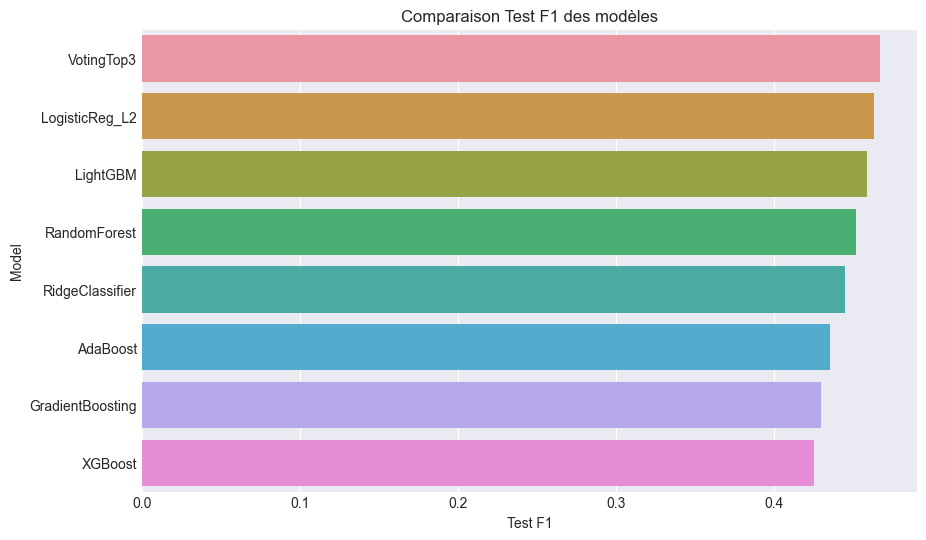

In [ ]:
fig = plt.figure(figsize=(10,6))
sorted_df = results_df.sort_values('Test F1', ascending=False)
sns.barplot(x='Test F1', y='Model', data=sorted_df)
plt.title('Comparaison Test F1 des modèles')
save_fig(fig, 'model_f1_comparison.png')
fig.show()

 ✓ Sauvegardé: figures\confusion_matrix_best.png


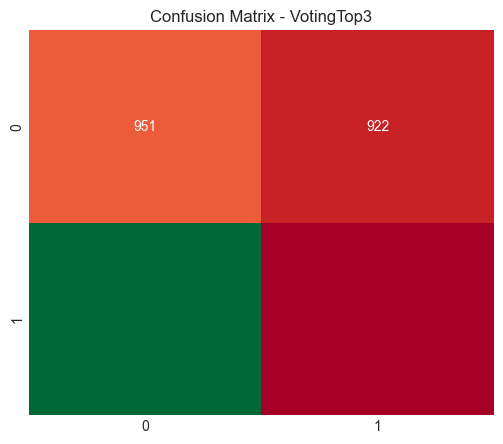

In [ ]:
try:
    fig = plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn', cbar=False)
    plt.title(f'Confusion Matrix - {final_best}')
    save_fig(fig, 'confusion_matrix_best.png')
    fig.show()
except Exception as e:
    print(' Heatmap skipped:', e)

SAUVEGARDE MODELES ET TRANSFORMEURS

In [ ]:
try:
    model_filename = f'best_ethics_model_{final_best.replace(" ", "_")}.pkl'
    joblib.dump(results[final_best]['model'], model_filename)
    print(f"✓ Meilleur modèle sauvegardé: {model_filename}")
    try:
        pipeline_used = results[final_best]['model']
        fu = pipeline_used.named_steps.get('features', None)
        if fu is not None:
            for name, trans in fu.transformer_list:
                if name == 'text':
                    text_pipe = trans
                    try:
                        tfidf_vec = text_pipe.named_steps['tfidf'].vec_
                        joblib.dump(tfidf_vec, 'tfidf_vectorizer.pkl')
                        print('✓ TF-IDF sauvegardé: tfidf_vectorizer.pkl')
                    except Exception:
                        pass
                    try:
                        selector = text_pipe.named_steps['chi2']
                        joblib.dump(selector, 'feature_selector.pkl')
                        print('✓ Selector sauvegardé: feature_selector.pkl')
                    except Exception:
                        pass
                    try:
                        svd = text_pipe.named_steps['svd']
                        joblib.dump(svd, 'svd_reducer.pkl')
                        print('✓ SVD sauvegardé: svd_reducer.pkl')
                    except Exception:
                        pass
                if name == 'manual':
                    try:
                        scaler = trans.named_steps.get('scaler', None)
                        if scaler is not None:
                            joblib.dump(scaler, 'feature_scaler.pkl')
                            print('✓ Scaler sauvegardé: feature_scaler.pkl')
                    except Exception:
                        pass
    except Exception as e:
        print(' Extraction transformeurs failed:', e)

    results_df.to_csv('model_comparison_results.csv', index=False)
    print('✓ Résultats sauvegardés: model_comparison_results.csv')
except Exception as e:
    print(' Erreur sauvegarde:', e)

✓ Meilleur modèle sauvegardé: best_ethics_model_VotingTop3.pkl
 ⚠️ Extraction transformeurs failed: 'VotingClassifier' object has no attribute 'named_steps'
✓ Résultats sauvegardés: model_comparison_results.csv


FONCTION DE PREDICTION

In [ ]:
def predict_ethics(text, return_proba=False):
    """
    Prédit si un texte est éthique ou non en appliquant la même pipeline.
    return_proba: si True et si disponible renvoie les probabilités.
    """
    processed = preprocess_text(text)
    temp_df = pd.DataFrame({'input':[text], 'processed':[processed]})
    model = results[final_best]['model']

    prediction = model.predict(temp_df)[0]
    if return_proba:
        proba = None
        try:
            if hasattr(model, 'predict_proba'):
                proba = model.predict_proba(temp_df)[0]
            elif hasattr(model, 'decision_function'):
                scores = model.decision_function(temp_df)
                from scipy.special import expit
                if np.ndim(scores) == 0:
                    p1 = expit(scores)
                    proba = np.array([1-p1, p1])
                else:
                    from scipy.special import softmax
                    proba = softmax(scores)
        except Exception:
            proba = None

        res = {'prediction': int(prediction), 'label': 'Éthique' if prediction==1 else 'Non Éthique'}
        if proba is not None:
            res.update({'confidence': float(max(proba)), 'proba_non_ethique': float(proba[0]), 'proba_ethique': float(proba[1])})
        return res

    return int(prediction)

In [26]:
if __name__ == '__main__':
    examples = [
        "A man's wife is dying from a rare disease. The only drug that can save her costs $10,000, which he cannot afford. The pharmacist refuses to lower the price or accept payments. The man considers breaking into the pharmacy to steal the medicine.",
        "An employee admits a mistake to their manager instead of blaming a colleague."
    ]
    for ex in examples:
        try:
            r = predict_ethics(ex, return_proba=True)
            print('\nTexte:', ex[:120] + '...')
            print(' =>', r)
        except Exception as e:
            print('Erreur prédiction:', e)


Texte: A man's wife is dying from a rare disease. The only drug that can save her costs $10,000, which he cannot afford. The ph...
 => {'prediction': 1, 'label': 'Éthique', 'confidence': 0.5986357525518963, 'proba_non_ethique': 0.4013642474481037, 'proba_ethique': 0.5986357525518963}

Texte: An employee admits a mistake to their manager instead of blaming a colleague....
 => {'prediction': 0, 'label': 'Non Éthique', 'confidence': 0.5606290584834945, 'proba_non_ethique': 0.5606290584834945, 'proba_ethique': 0.43937094151650463}
